<a href="https://colab.research.google.com/github/tejaspradhan/Graph-Neural-Networks/blob/main/code/GNN_Molecule_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Water Solubility of a Molecule 
The molecule is represented as a graph.
 
This is a graph classification problem

## Installation of Pytorch and RDKit

In [1]:
# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!python --version
!nvidia-smi

1.10.0+cu111
11.1
Python 3.7.12
Sun Jan  2 06:20:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                        

In [2]:
#@title
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


In [3]:
! pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-cluster -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
! pip install -q torch-geometric

In [4]:
import rdkit
from torch_geometric.datasets import MoleculeNet
import numpy as np

## Exploring the Dataset

In [5]:
data = MoleculeNet(root=".", name="ESOL")
data

ESOL(1128)

In [6]:
len(data)

1128

In [7]:
# number of features in the graph
data.num_features

9

In [8]:
# Target classes
data.num_classes

734

In [9]:
data[0]

Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')

In [10]:
data[0].x.shape # matrix of 32x9 --> 32 nodes and 9 features of each node

torch.Size([32, 9])

In [11]:
data[0].y # 1 target variable. Regression problem or Graph level prediction problem 

tensor([[-0.7700]])

In [12]:
data[0].smiles

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

In [13]:
print(data[0].edge_index.t().shape) # 68 edges 

torch.Size([68, 2])


**Visualising the Molecule Data**

In [14]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

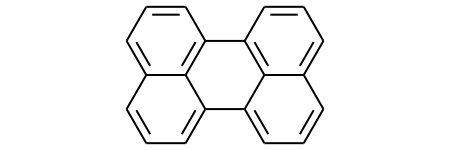

In [15]:
index = np.random.randint(0,len(data))
molecule = Chem.MolFromSmiles(data[index]["smiles"])
molecule

## Implementing the Graph Neural Network

In [28]:
# importing libraries specific to the GNN 
import torch
from torch.nn import Linear
from torch import tanh 
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool ,global_max_pool

In [17]:
class GNN(torch.nn.Module):
  def __init__(self):
    # calling parent class
    super(GNN,self).__init__()
    torch.manual_seed(42)
    
    # defining GNN layers
    self.conv0 = GCNConv(data.num_features,64)
    self.conv1 = GCNConv(64,64)
    self.conv2 = GCNConv(64,64)
    self.conv3 = GCNConv(64,64)
    self.out = Linear(128,1)

  def forward(self,node_features, edge_index,batch_index):
    hidden = self.conv0(node_features,edge_index)
    hidden = tanh(hidden)
    hidden = self.conv1(hidden, edge_index)
    hidden = self.conv2(hidden, edge_index)
    hidden = tanh(hidden)
    hidden = self.conv3(hidden, edge_index)
    hidden = tanh(hidden)
    # Here we are doing a concatenation of Global mean pooling and Global average pooling which results into a vector of size 128 (64+64)
    hidden = torch.cat([global_mean_pool(hidden, batch_index), 
                            global_max_pool(hidden, batch_index)], dim=1)
    out = self.out(hidden)
    return out, hidden

In [18]:
model = GNN()

In [19]:
print(model)

GNN(
  (conv0): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


## Training the GNN

In [20]:
from torch_geometric.loader import DataLoader
L = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [21]:
# Splitting into training and testing
train_loader = DataLoader(data[:int(len(data) * 0.7)], 
                    batch_size=64, shuffle=True)
test_loader = DataLoader(data[int(len(data) * 0.7):], 
                         batch_size=64, shuffle=True)

In [22]:
## Writing the function for one complete forward and backward pass
def train(data):
  for batch in train_loader:
    batch.to(device)  
    # Reset gradients
    optimizer.zero_grad() 
    # Passing the node features and the connection info
    pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch) 
    # Calculating the loss and gradients
    loss = torch.sqrt(L(pred, batch.y)) # root mean squared error       
    loss.backward()  
    # Update using the gradients
    optimizer.step()   
  return loss

In [24]:
loss_vals = []
for epoch in range(1000):
  loss_value = train(data)
  loss_vals.append(loss_value)
  if(epoch%100==0):
    print("Epoch: ",epoch, "Loss: ",loss_value.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  0 Loss:  0.907365620136261
Epoch:  100 Loss:  0.7040682435035706
Epoch:  200 Loss:  0.4362868666648865
Epoch:  300 Loss:  0.7023819088935852
Epoch:  400 Loss:  0.40068602561950684
Epoch:  500 Loss:  0.28143152594566345
Epoch:  600 Loss:  0.37635189294815063
Epoch:  700 Loss:  0.2479272186756134
Epoch:  800 Loss:  0.46949735283851624
Epoch:  900 Loss:  0.3084854781627655


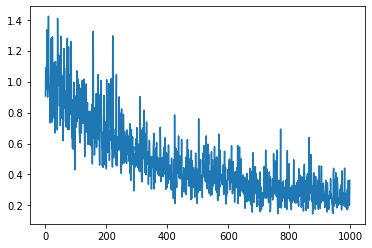

In [25]:
import matplotlib.pyplot as plt 
plt.plot(range(1000),loss_vals)

In [29]:
test_losses = []
with torch.no_grad():
  for batch in test_loader:
    batch.to(device)  
    pred,embedding = model(batch.x.float(),batch.edge_index,batch.batch)
    loss = torch.sqrt(L(pred,batch.y))
    print(loss.item())
    test_losses.append(loss)


0.8828230500221252
0.8833389282226562
0.7648510932922363
1.0542010068893433
0.9714773297309875
0.5583273768424988


In [34]:
print("Mean Test Loss",torch.mean(torch.tensor(test_losses)).item())

Mean Test Loss 0.8525031208992004
